In [130]:
import os, sys, pathlib
import importlib
import pandas as pd

ROOT = pathlib.Path.cwd().resolve()
SRC = os.path.join(ROOT, "src")

if SRC not in sys.path:
    sys.path.insert(0, str(SRC))
    print(f"Added {SRC} to system path")
else:
    print(f"{SRC} already exists in system path")

# auto-reload any module that changes on disk
%load_ext autoreload
%autoreload 2

/Users/jamesbyers/code/github/Kaggle/openai_to_z/src already exists in system path
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
# imports from ./src
import lidar_utils.io
import lidar_utils.lidar
import lidar_utils.raster
import lidar_utils.vis

In [189]:
path_to_yaml = "config/paths.yml"
doi = "10.3334/ORNLDAAC/1644"

In [101]:
importlib.reload(lidar_utils.io);

In [192]:
CONFIG = lidar_utils.io.load_paths_yaml(path_to_yaml, verbose=False)
CONFIG

{'raw_laz': PosixPath('data/raw/tiles/laz'),
 'raw_sat': PosixPath('data/raw/tiles/sat'),
 'raw_meta': PosixPath('data/raw/metadata'),
 'dtm_dir': PosixPath('data/derived/dtm'),
 'dsm_dir': PosixPath('data/derived/dsm'),
 'chm_dir': PosixPath('data/derived/chm'),
 'pdal_tpl_dir': PosixPath('config/pdal_pipelines')}

In [104]:
lidar_utils.io.authenticate_earthaccess();

Successfully authenticated with earthaccess.


In [119]:
metadata = lidar_utils.io.get_metadata(doi = doi, verbose=False)

In [121]:
df= pd.read_csv(lidar_utils.io.download_earthaccess_dataset_csv(metadata["concept_id"]))

QUEUEING TASKS | : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1042.84it/s]
PROCESSING TASKS | : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.45s/it]
COLLECTING RESULTS | : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


In [126]:
df.head(1)

,filename,max_lat,min_lat,max_lon,min_lon,file_type,file_size_mb,file_format,version,created,utmzone,srs
0,ANA_A01_2017_laz_0.laz,-3.363488,-3.372548,-54.992912,-55.001927,pointcloud,85.374953,LAS/LAZ,1.2,214/2017,21S,+proj=utm +zone=21 +south +ellps=GRS80 +towgs8...


### ChatGPT o3 generated skeleton code for testing src/lidar_utils/*.py functions

In [165]:
### Setup environment and import required python packages
import sys
import pathlib
import logging
import os

import earthaccess
import pandas as pd

ROOT = os.getcwd()    # project root
SRC  = os.path.join(ROOT, "src")
if SRC not in sys.path:
    sys.path.insert(0, str(SRC))

%load_ext autoreload
%autoreload 2

from lidar_utils import io, satellite, lidar, raster, vis

logging.basicConfig(level=logging.INFO, format="%(levelname)s│%(name)s│%(message)s")

P = io.load_paths_yaml(
    os.path.join(
        ROOT,
        "config",
        "paths.yml"
    ), verbose=False
)

io.authenticate_earthaccess()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO│lidar_utils.io│earthaccess authenticated


True

In [209]:
### Download dataset metadata csv
dataset = io.get_metadata()
concept_id = dataset["meta"]["concept-id"]

dataset_csv_path = io.download_earthaccess_dataset_csv(
    concept_id=concept_id,
    dest=P["raw_meta"],
    overwrite=True
)

In [214]:
df = pd.read_csv(dataset_csv_path)
df.head(1)

,filename,max_lat,min_lat,max_lon,min_lon,file_type,file_size_mb,file_format,version,created,utmzone,srs
0,ANA_A01_2017_laz_0.laz,-3.363488,-3.372548,-54.992912,-55.001927,pointcloud,85.374953,LAS/LAZ,1.2,214/2017,21S,+proj=utm +zone=21 +south +ellps=GRS80 +towgs8...


In [204]:
filename = df.iloc[0]["filename"]
laz_path = io.fetch_laz_file(filename, P["raw_laz"])

ANA_A01_2017_laz_0.laz already exists in data/raw/tiles/laz, skipping download.


In [216]:
satellite.fetch_esri(
    tile_bbox=(-1.0, 52.0, -0.99, 52.01),   # (min_lon, min_lat, max_lon, max_lat)
    out_jpg=pathlib.Path("data/raw/tiles/sat/tile_123_456.jpg"),
    px=1024,                                # longest side in pixels
)

INFO│lidar_utils.satellite│ESRI basemap ~6kB → data/raw/tiles/sat/tile_123_456.jpg


PosixPath('data/raw/tiles/sat/tile_123_456.jpg')

In [ ]:
raw_sat_dir = pathlib.Path(P["raw_sat"])
raw_sat_file = raw_sat_dir / f"{filename}.jpg"

img = satellite.fetch_esri_from_row(df, filename=filename, save_path=raw_sat_file)


ANA_A01_2017_laz_0.laz


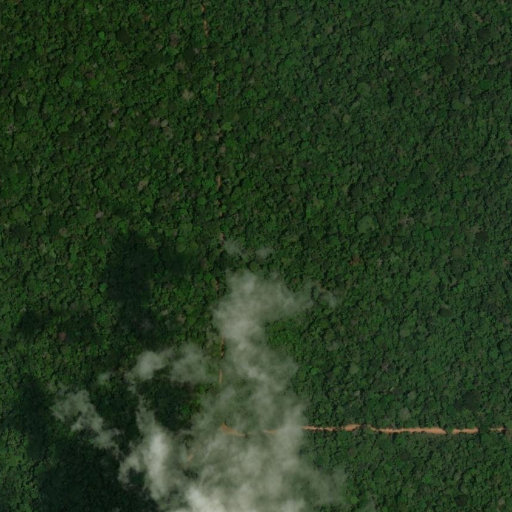

In [233]:
print(filename)
img

In [237]:
filename

'ANA_A01_2017_laz_0.laz'

In [293]:
import json

def load_filter_spec(spec_path: str) -> list:
    """Read a JSON file whose root object is {'pipeline': [ …filters… ]}."""
    with open(spec_path, "r") as f:
        return json.load(f)["pipeline"]
    
def build_pipeline(laz_path, filters, out_tif,
            res=2.0, out_type="idw",
            bounds=None, spatialreference=None,
            nodata=-9999):                    # NEW default
    writer = {
        "type": "writers.gdal",
        "filename": out_tif,
        "gdaldriver": "GTiff",
        "resolution": res,
        "output_type": out_type,
        "nodata": nodata                       # NEW
    }
    if bounds:
        writer["bounds"] = bounds
    if spatialreference:                     # NEW
        writer["spatialreference"] = spatialreference

    return {"pipeline": [laz_path] + filters + [writer]}

def run_pipeline(pipeline_def: dict) -> None:
    """Execute a PDAL pipeline."""
    p = pdal.Pipeline(json.dumps(pipeline_def))
    p.execute()

dtm_filters = load_filter_spec(os.path.join("config/pdal_pipelines", "dtm_template.json"))

dtm_path = os.path.join(str(P["dtm_dir"]), f"{filename.split('.')[0]}.tif")
print(dtm_path)

row = df[df["filename"] == filename]
if row.empty:
    raise ValueError(f"No entry for filename {filename}")

# Extract bounds
min_lat = row["min_lat"].values[0]
max_lat = row["max_lat"].values[0]
min_lon = row["min_lon"].values[0]
max_lon = row["max_lon"].values[0]
bbox = (min_lon, min_lat, max_lon, max_lat)
# bbox = f"([{min_x},{max_x}], [{min_y},{max_y}])"
bbox = f"([{min_lon},{max_lon}], [{min_lat},{max_lat}])"

dtm_pipe = build_pipeline(str(laz_path), dtm_filters, dtm_path, bounds=bbox, spatialreference=None)
run_pipeline(dtm_pipe)

data/derived/dtm/ANA_A01_2017_laz_0.tif


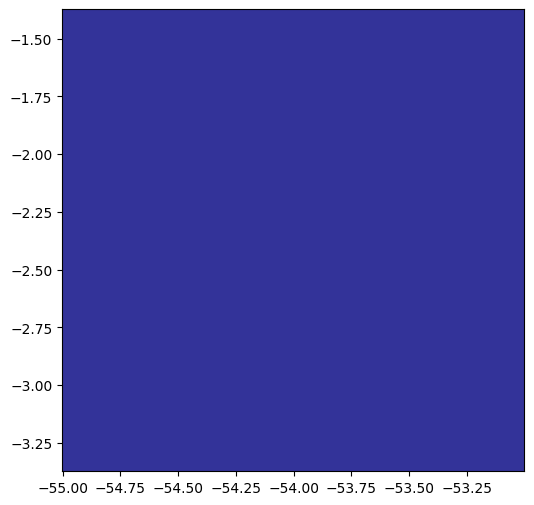

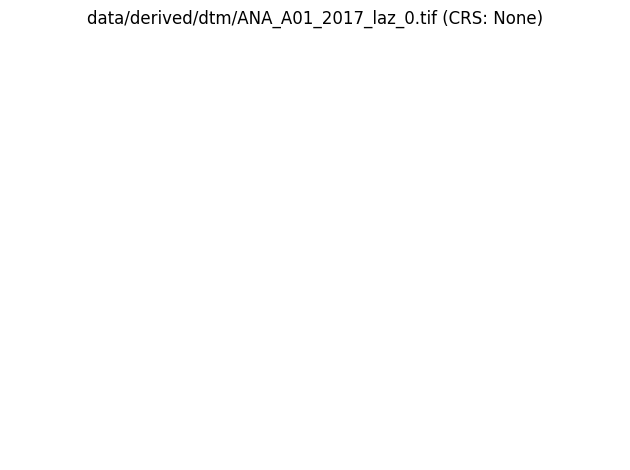

In [294]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Replace with the path to your GeoTIFF
tif_path = dtm_path

# Open the GeoTIFF
with rasterio.open(tif_path) as src:
    data = src.read(1)  # read the first (and often only) band
    transform = src.transform
    crs = src.crs

# Plot with matplotlib
plt.figure(figsize=(8, 6))
show(data, transform=transform, cmap="terrain")
plt.title(f"{tif_path} (CRS: {crs})")
# plt.colorbar(label="Elevation (m)", orientation="vertical", fraction=0.046, pad=0.04)
plt.axis("off")
plt.tight_layout()
plt.show()

In [254]:
import json
import pdal

# Build a minimal pipeline that declares filters.csf with one known‐good argument
test_pipeline = {
    "pipeline": [
        { "type": "filters.csf", "cloth_resolution": 1.0 },
        # We won’t actually write output—just see if PDAL knows filters.csf at all.
    ]
}

try:
    p = pdal.Pipeline(json.dumps(test_pipeline))
    p.validate()
    print("✓ filters.csf appears to be present in this build.")
except RuntimeError as e:
    print("✗ filters.csf is NOT available (or its minimal 'cloth_resolution' isn’t accepted).")
    print("  Error message:", e)


AttributeError: 'Pipeline' object has no attribute 'validate'

In [257]:
import json, pdal, pathlib

# You need a minimal valid reader–filter–writer chain. Use any small .laz you have:
dummy_laz = "/path/to/a/real.laz"
dummy_out = "/tmp/fake.tif"

# Candidate CSF arguments to test
candidates = [
    ("cloth_resolution", 1.0),
    ("rigidness", 3.0),
    ("time_step", 0.65),
    ("class_threshold", 0.5),
    ("iterations", 500),
    ("slope", 0.2),
    ("detect_breaklines", False),
    ("approximate", False),
]

supported = []
for key, val in candidates:
    # Build a tiny pipeline that read the dummy LAS, applies CSF with the candidate key, then writes a dummy TIF.
    pipeline_dict = {
        "pipeline": [
            { "type": "readers.las", "filename": dummy_laz },
            {
                "type": "filters.csf",
                key: val
            },
            {
                "type": "writers.gdal",
                "filename": dummy_out,
                "resolution": 1.0,
                "output_type": "min",
                "data_type": "float"
            }
        ]
    }
    try:
        p = pdal.Pipeline(json.dumps(pipeline_dict))
        # If construction alone doesn’t catch the bad key, try executing just enough to validate the filter args.
        # We know dummy_laz exists; so if the parameter is invalid, execute() will complain about "Unexpected argument".
        p.execute()
        supported.append(key)
    except RuntimeError as e:
        msg = str(e).lower()
        if "unexpected argument" in msg or "unknown filter" in msg:
            # This key is not supported by filters.csf in this build
            pass
        else:
            # Some other error (e.g. missing writer driver), but the key itself
            # was accepted. We count it as supported.
            supported.append(key)

print("Supported CSF keys in this build:", supported)


Supported CSF keys in this build: ['cloth_resolution', 'rigidness', 'time_step', 'class_threshold', 'iterations', 'slope', 'detect_breaklines', 'approximate']
